@Author: Dev Bharti
Prior understanding of FastAI tabular model is necessary. Refer to their video 4 for more information (https://course.fast.ai/videos/?lesson=4)

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *


Bad key "text.kerning_factor" on line 4 in
/home/dev/anaconda3/envs/deep_ai/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Create the dataframe from CSV and remove unnecessary columns

In [211]:
df_orig = pd.read_csv('OUTPUT_WBI_exposer_cyclones_v10.csv')

In [212]:
df_orig_del_columns = df_orig.drop(['SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'DAY_HRS', 'NIGHT_HRS', 'in_wbi',
                 '34KN_POP', '34KN_ASSETS', '64KN_POP', '64KN_ASSETS', '96KN_POP', '96KN_ASSETS'], 
                 axis = 1)

In [213]:
train_df = df_orig_del_columns[:1000]
test_df = df_orig_del_columns[1000:]

In [214]:
len(df_orig_del_columns), len(train_df), len(test_df)

(1005, 1000, 5)

In [215]:
# Adding month per Vamsi's code in SVM folder
train_df['Month'] = train_df.ISO_TIME.apply(lambda x: x[7:9]).astype(int)
test_df['Month'] = train_df.ISO_TIME.apply(lambda x: x[7:9]).astype(int)

<ipython-input-215-49c5d73420ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Month'] = train_df.ISO_TIME.apply(lambda x: x[7:9]).astype(int)
<ipython-input-215-49c5d73420ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Month'] = train_df.ISO_TIME.apply(lambda x: x[7:9]).astype(int)


In [216]:
train_df['Month'].unique()

array([ 6,  9,  8, 12,  7, 10, 11,  5,  1,  2,  4,  3])

In [217]:
# # Using Xavier's CPI logic...
# train_df["TOTAL_DAMAGE_(000$)_Adjusted"]= train_df["TOTAL_DAMAGE_(000$)"] / train_df["CPI"]
# train_df["TOTAL_DAMAGE_(000$)_Adjusted"]= train_df["TOTAL_DAMAGE_(000$)_Adjusted"].replace(0, np.nan)
# train_df = train_df.drop(["TOTAL_DAMAGE_(000$)",'CPI'], axis=1)
# df["TOTAL_DAMAGE_(000$)_Adjusted"].isna().sum()

In [218]:
# len(df_mod)/16

In [185]:
train_df.isna().sum()

Unnamed: 0                                               0
BASIN                                                    0
SUB BASIN                                                0
NATURE                                                   0
ISO_TIME                                                 0
TOTAL_HRS                                                0
USA_SSHS                                                 0
WIND_CALC_MEAN                                           4
PRES_CALC_MEAN                                           0
STORM_SPD_MEAN                                           0
STORM_DR_MEAN                                            0
V_LAND_KN                                                0
CPI                                                      0
TOTAL_DAMAGE_(000$)                                    317
TOTAL_DEATHS                                           134
Air transport, freight (million ton-km)                154
Arable land (hectares per person)                       

# Prepare the categorical variables and continous variables to be passed to the Tabular Model

In [219]:
dep_var = 'TOTAL_AFFECTED'

cat_names = ['BASIN', 
             'SUB BASIN', 
             'NATURE', 
             'Income_level_Final', 
             'USA_SSHS',
             'Month']

cont_names = ['TOTAL_HRS',
              'PRES_CALC_MEAN', 
              'STORM_SPD_MEAN', 
              'STORM_DR_MEAN',
              'Mobile cellular subscriptions (per 100 people)',
              'Population density (people per sq. km of land area)',
              'V_LAND_KN',
              'Arable land (hectares per person)',
              'GDP per capita (constant 2010 US$)',
              'Air transport, freight (million ton-km)',
              'Cereal yield (kg per hectare)',
              'Food production index (2004-2006 = 100)',
              'GDP growth (annual %)',
              'Life expectancy at birth, total (years)',
              'Adjusted savings: education expenditure (% of GNI)',
              'Rural population (% of total population)']

# cont_names_new = ['TOTAL_HRS',
#               'PRES_CALC_MEAN', 
#               'STORM_SPD_MEAN', 
#               'STORM_DR_MEAN',
#               'V_LAND_KN']

#Features not used:
# WIND_CALC_MEAN
# 34KN_POP
# 34KN_ASSETS
# 64KN_POP
# 64KN_ASSETS
# 96KN_POP
# 96KN_ASSETS
# Net flows from UN agencies US$
# pop_max_34                                              
# pop_max_50                                              
# pop_max_64                                              
# pop_max_34_adj                                          
# pop_max_50_adj                                          
# pop_max_64_adj 
# Total Deaths

In [220]:
#FillMissing populates the NA values with Medians. Categorify converts categorical variables 
# into category data types and Normalise normalises the continous variables.
procs=[FillMissing, Categorify, Normalize]

In [221]:
#Helper function to generate a DataBunch from a dataframe, taking into account parameters
#log = True enables logs to be used for target variable (Total Affected)
data = (TabularList.from_df(train_df, path='.', cat_names=cat_names, cont_names=cont_names, procs=procs)
                .split_by_rand_pct(0.25)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path='.', cat_names=cat_names, cont_names=cont_names))
                .databunch())

# data_new = (TabularList.from_df(df_mod_new, path='.', cat_names=cat_names, cont_names=cont_names_new, procs=procs)
#                 .split_by_rand_pct()
#                 .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
#                 .databunch())

In [222]:
len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(750, 250, 5)

In [117]:
# data_new.show_batch(10)

# Build the model

In [118]:
#Provides an upperbound for target variable
max_log_y = np.log(np.max(df_mod[dep_var])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

# max_log_y = np.log(1.2) + np.max(df_mod[dep_var])
# y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [223]:
# creates a learner with embeddings
learn = tabular_learner(data, 
                        layers=[10, 5], 
                        loss_func = MSELossFlat(),
#                         y_range = y_range, 
                        metrics= [mae, accuracy, msle, rmse, exp_rmspe], 
                        ps=[0.001,0.01], 
                        emb_drop=0.02)

In [224]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(7, 5)
    (1): Embedding(13, 7)
    (2): Embedding(7, 5)
    (3): Embedding(5, 4)
    (4): Embedding(12, 6)
    (5): Embedding(13, 7)
    (6): Embedding(3, 3)
    (7): Embedding(3, 3)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.02, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=77, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=10, out_features=5, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


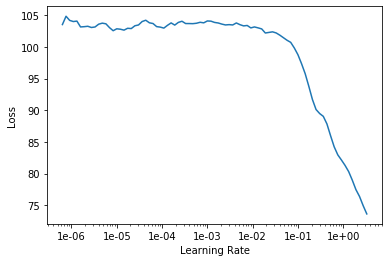

In [225]:
learn.lr_find()
learn.recorder.plot()

In [226]:
# learn.fit_one_cycle(10, 1e-2, wd=0.1)
learn.fit(10, 1e-01)

epoch,train_loss,valid_loss,mean_absolute_error,accuracy,mean_squared_logarithmic_error,root_mean_squared_error,exp_rmspe,time
0,65.078018,41.172279,5.378647,0.000000,nan,6.411413,3239.756836,00:00
1,36.826771,10.167451,2.511729,0.000000,0.136520,3.174265,3136.821045,00:00
2,25.935835,12.923314,3.037140,0.000000,0.183129,3.592761,829.953491,00:00
3,20.086538,9.674268,2.387739,0.000000,0.134780,3.095593,4071.474121,00:00
4,16.483236,8.702231,2.407971,0.000000,0.117141,2.942888,983.271790,00:00
5,14.130857,9.145474,2.384398,0.000000,0.127671,3.013569,3057.497803,00:00
6,12.549947,8.985952,2.466369,0.000000,0.117339,2.990523,532.773743,00:00
7,11.433789,8.916782,2.385582,0.000000,0.124176,2.972871,1783.437012,00:00
8,10.598133,9.155086,2.438663,0.000000,0.125582,3.011759,1606.753296,00:00
9,9.971399,8.710348,2.355477,0.000000,0.121129,2.942345,976.052551,00:00


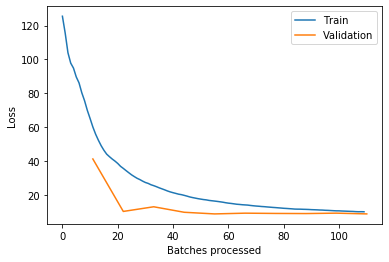

In [227]:
learn.recorder.plot_losses()

In [168]:
# learn.recorder.plot_metrics()

In [287]:
test_preds, _ = learn.get_preds(DatasetType.Test)
test_preds, np.exp(test_preds)

(tensor([[10.6720],
         [10.6459],
         [10.5708],
         [10.7143],
         [13.0811]]),
 tensor([[ 43131.0273],
         [ 42021.9531],
         [ 38979.8008],
         [ 44993.2461],
         [479767.7812]]))

In [285]:
test_df[dep_var].values

array([    1100,  1501500,   345311,   400094, 20000000])

In [278]:
# np.exp(test_preds).squeeze().shape
# test_df[dep_var].values
# a = torch.from_numpy(test_df[dep_var].values)
# a.shape

In [279]:
# accuracy(np.exp(test_preds).squeeze(), a)